In [11]:
import os
import zipfile

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
df='/content/data.zip'

In [14]:
df

'/content/data.zip'

In [15]:
df1=zipfile.ZipFile(df,'r')

In [16]:
df1.extractall('/content/data')

In [17]:
df1.close()

In [19]:
os.listdir('/content/data/data/')

['data_test.csv', 'data_train.csv']

In [20]:
!pip install ktrain

     |████████████████████████████████| 25.3 MB 101 kB/s 
     |████████████████████████████████| 6.8 MB 37.9 MB/s 
     |████████████████████████████████| 981 kB 38.4 MB/s 
     |████████████████████████████████| 263 kB 50.4 MB/s 
     |████████████████████████████████| 1.9 MB 37.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.2 MB/s 
     |████████████████████████████████| 468 kB 47.2 MB/s 
     |████████████████████████████████| 3.3 MB 35.7 MB/s 
     |████████████████████████████████| 895 kB 39.0 MB/s 
  Created wheel for ktrain: filename=ktrain-0.27.3-py3-none-any.whl size=25283131 sha256=f9715f4e0bcf916299ce2d779a0c6d4a98c46209defc003e057b1befb8872046
  Stored in directory: /root/.cache/pip/wheels/3c/ef/e1/7da805d8a5944e8a3ac0553831d832c00b1800b848939849cb
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=cb59f1639b95f5b819946cdbda22173bf67b4f2ce90370590ff265059be03d2d
  Stored in directory: /root/.cache/pip/wheels/f5/ac/f1/4e13d7aff

In [21]:
import pandas as pd
import numpy as np

import ktrain
from ktrain import text

In [23]:
data_train = pd.read_csv('/content/data/data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/data/data/data_test.csv', encoding='utf-8')

X_train = data_train.Text.tolist()
X_test = data_test.Text.tolist()

y_train = data_train.Emotion.tolist()
y_test = data_test.Emotion.tolist()

data = data_train.append(data_test, ignore_index=True)

class_names = ['joy', 'sadness', 'fear', 'anger', 'neutral']

print('size of training set: %s' % (len(data_train['Text'])))
print('size of validation set: %s' % (len(data_test['Text'])))
print(data.Emotion.value_counts())

data.head(10)

size of training set: 7934
size of validation set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


In [24]:
encoding = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}

# Integer values for each class
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [25]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [26]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350
done.


In [27]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

In [28]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1323/1323 [==============================] - 1603s 1s/step - loss: 0.9381 - accuracy: 0.6423 - val_loss: 0.5785 - val_accuracy: 0.7955
Epoch 2/3
1323/1323 [==============================] - 1573s 1s/step - loss: 0.4535 - accuracy: 0.8462 - val_loss: 0.5284 - val_accuracy: 0.8214
Epoch 3/3
1323/1323 [==============================] - 1573s 1s/step - loss: 0.1958 - accuracy: 0.9401 - val_loss: 0.5771 - val_accuracy: 0.8252


In [29]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

              precision    recall  f1-score   support

         joy       0.86      0.84      0.85       707
     sadness       0.80      0.82      0.81       676
        fear       0.87      0.84      0.86       679
       anger       0.79      0.79      0.79       693
     neutral       0.82      0.83      0.82       638

    accuracy                           0.83      3393
   macro avg       0.83      0.83      0.83      3393
weighted avg       0.83      0.83      0.83      3393



array([[597,  21,  15,  17,  57],
       [ 17, 557,  27,  57,  18],
       [ 22,  31, 571,  44,  11],
       [ 17,  67,  31, 545,  33],
       [ 45,  23,  10,  30, 530]])

In [30]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['joy', 'sadness', 'fear', 'anger', 'neutral']

In [39]:
import time 

message = "Hello ?"

start_time = time.time() 
prediction = predictor.predict(message)

print('predicted: {} ({:.2f})'.format(prediction, (time.time() - start_time)))

predicted: neutral (0.22)


In [40]:
predictor.save("models/bert_model")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [41]:
import matplotlib.pyplot as plt


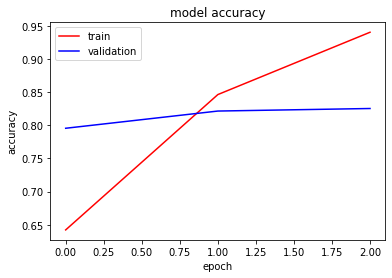

In [45]:
plt.plot(learner.history.history['accuracy'],'r')
plt.plot(learner.history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(r"\bert_acc.png")
plt.show()

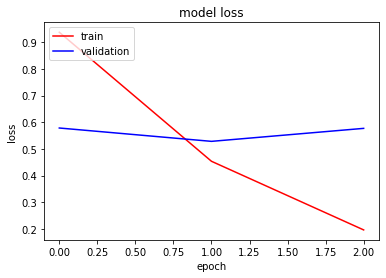

In [47]:
plt.plot(learner.history.history['loss'],'r')
plt.plot(learner.history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(r"\bert_loss.png")
plt.show()
